## 10.3 Forecasting
To forecast using a regression model with ARIMA errors, we need to forecast the regression part of the model and the ARIMA part of the model, and combine the results. As with ordinary regression models, in order to obtain forecasts we first need to forecast the predictors. When the predictors are known into the future (e.g., calendar-related variables such as time, day-of-week, etc.), this is straightforward. But when the predictors are themselves unknown, we must either model them separately, or use assumed future values for each predictor.

It is important to realise that the prediction intervals from regression models (with or without ARIMA errors) do not take into account the uncertainty in the forecasts of the predictors. So they should be interpreted as being conditional on the assumed (or estimated) future values of the predictor variables.

### Example: Forecasting electricity demand
Daily electricity demand can be modelled as a function of temperature. As can be observed on an electricity bill, more electricity is used on cold days due to heating and hot days due to air conditioning. The higher demand on cold and hot days is reflected in the U-shape of Figure 10.5, where daily demand is plotted versus daily maximum temperature.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
from utils import *

In [70]:
df = pd.read_csv('../data/tsibbledata/vic_elec.csv', parse_dates=['Time'])

In [71]:
vic_elec_daily = (
    df.query("Time.dt.year == 2014")
    .set_index("Time", drop=False)
    .resample("1d")
    .agg(dict(Demand="sum", Temperature="mean", Holiday="any", Time="min"))
    .assign(
        Demand=lambda df: df["Demand"] / 1.0e3,
        dow=lambda df: df["Time"].dt.strftime("%A"),
    )
).iloc[:-1]

In [72]:
vic_elec_daily["Day_type"] = np.where(
    vic_elec_daily["Holiday"],
    "Holiday",
    np.where(vic_elec_daily["dow"].isin(["Saturday", "Sunday"]), "Weekend", "Weekday"),
)

In [73]:
vic_elec_daily['Is_workday'] = np.where(
    vic_elec_daily['Day_type'].isin(['Holiday', 'Weekend']), False, True
)

In [20]:
from plotnine import geom_point

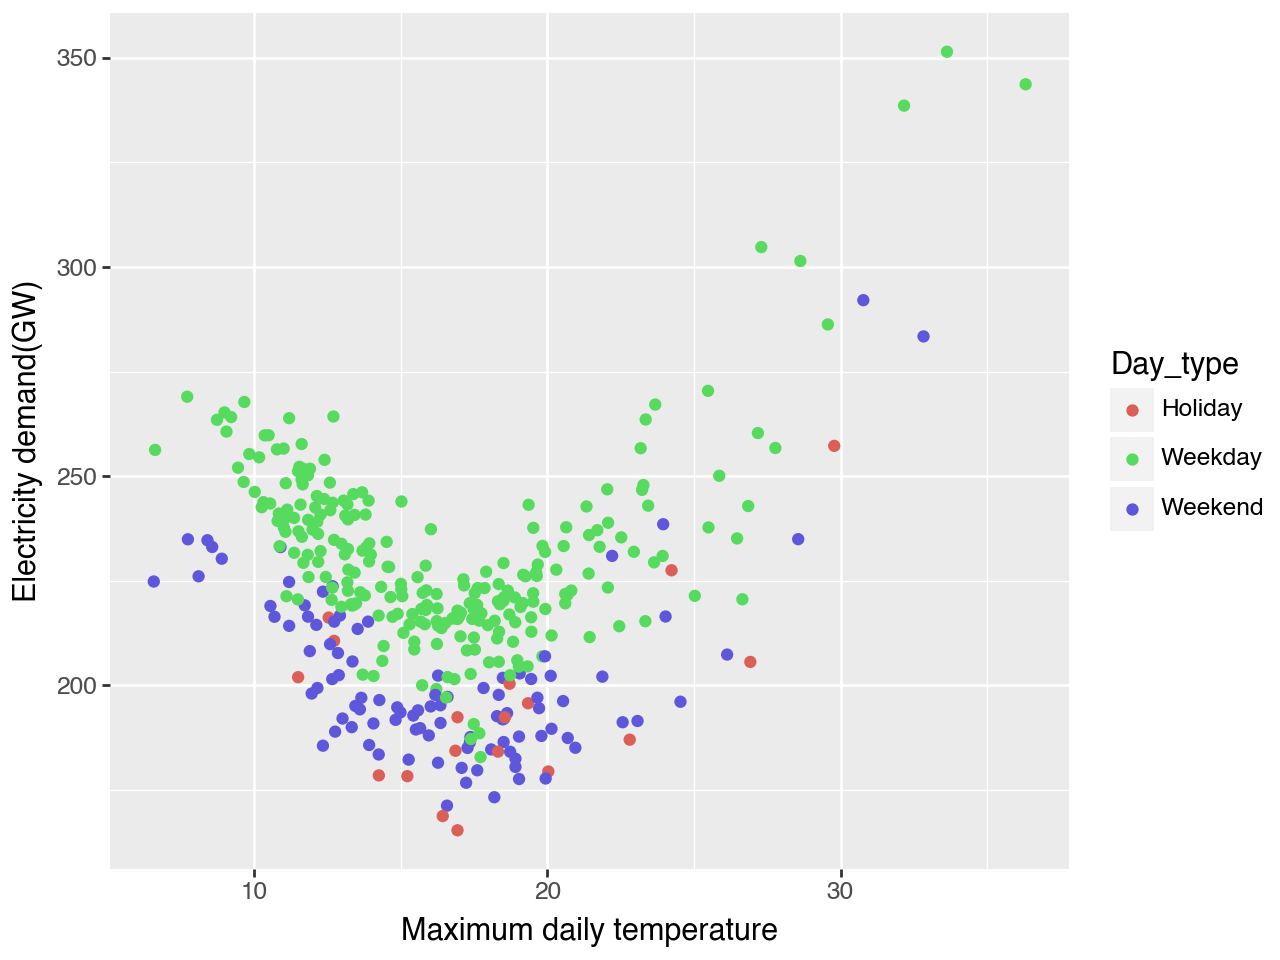

In [75]:
(
    ggplot(vic_elec_daily)
    + aes(x="Temperature", y="Demand", color="Day_type")
    + geom_point()
    + labs(x="Maximum daily temperature", y="Electricity demand(GW)")
)

In [76]:
demand_df = (
    pd.DataFrame(vic_elec_daily["Demand"])
    .assign(var="Demand")
    .rename(columns={"Demand": "value"})
)
temperature_df = (
    pd.DataFrame(vic_elec_daily["Temperature"])
    .assign(var="Temperature")
    .rename(columns={"Temperature": "value"})
)


Daily electricity demand and maximum daily temperature for the state of Victoria in Australia for 2014.

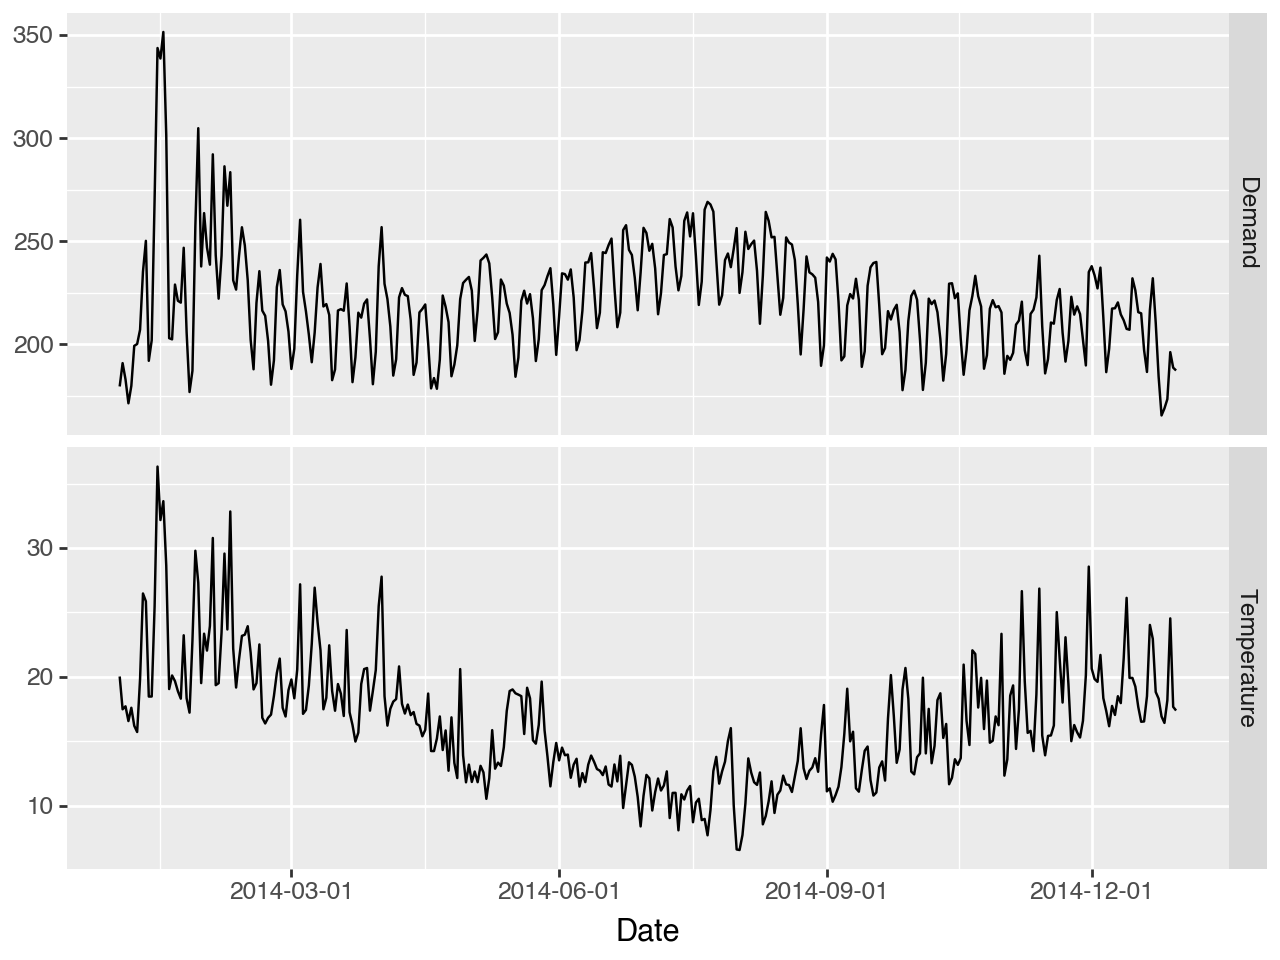

In [77]:
(
    ggplot(pd.concat([demand_df, temperature_df]).reset_index())
    + aes(x="Time", y="value")
    + facet_grid(rows="var", scales="free_y")
    + geom_line()
    + labs(y='', x='Date')
)


In [78]:
df2 = vic_elec_daily.copy()
df2['Temperature2'] = df2['Temperature']**2

In [79]:
fit = sm.tsa.statespace.SARIMAX(
    df2["Demand"],
    exog=df2[["Temperature", "Is_workday"]].astype(float),
    order=(2, 1, 2),
    seasonal_order=(2, 0, 0, 7),
).fit(disp=0)

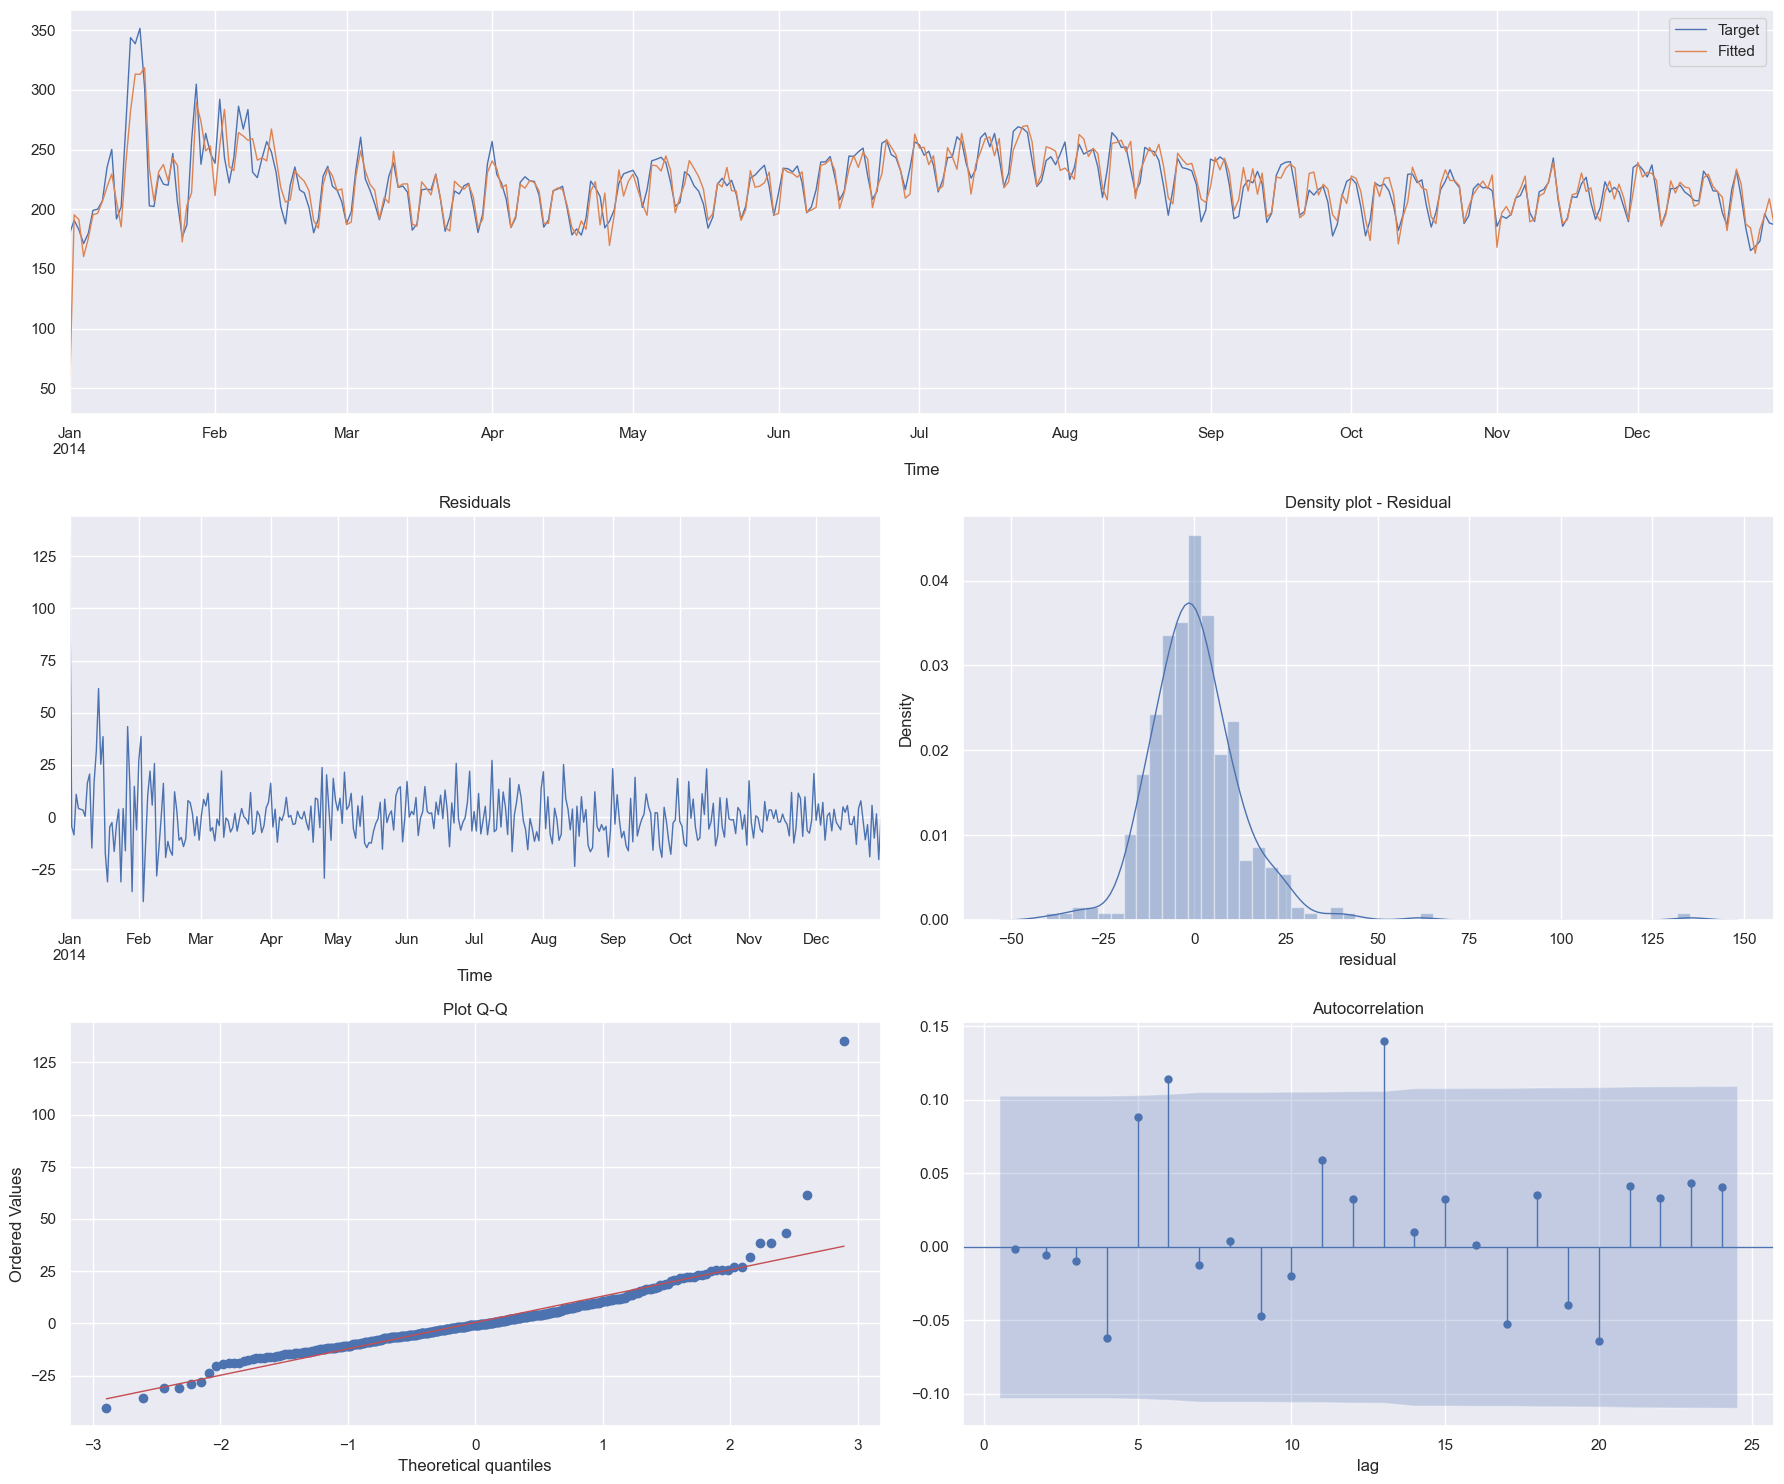

In [80]:
plot_fitted_residuals(fit)

In [81]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Demand   No. Observations:                  364
Model:             SARIMAX(2, 1, 2)x(2, 0, [], 7)   Log Likelihood               -1413.392
Date:                            Tue, 26 Nov 2024   AIC                           2844.785
Time:                                    15:27:37   BIC                           2879.835
Sample:                                01-01-2014   HQIC                          2858.717
                                     - 12-30-2014                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature     2.2020      0.149     14.769      0.000       1.910       2.494
Is_workday     21.4423      2.116     10.132      0.000      17.295      25.590
ar.L1           0.1302      0.131      0.994      0.320      -0.127       0.387
ar.L2           0.3227      0.114      2.822      0.005       0.099       0.547
ma.L1          -0.2312      0.115     -2.008      0.045      -0.457      -0.005
ma.L2          -0.6809      0.109     -6.246      0.000      -0.895      -0.467
ar.S.L7         0.1602      0.044      3.646      0.000       0.074       0.246
ar.S.L14        0.2292      0.048      4.746      0.000       0.135       0.324
sigma2        140.4588      8.984     15.634      0.000     122.850     158.068
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               125.78
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
sm.stats.acorr_ljungbox(fit.resid, lags=[14], model_df=6, boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
14,19.413019,0.0128,18.828422,0.015805


Looking at the residuals, we can see there is clear **heteroscedasiticity** (changes in variance), with variances higher in January and February, and lower variance in May. The model also has some significant autocorrelation in the residuals (as evidenced by the Ljung-Box test) and the histogram of the residuals showing long tails. All of these issues with the residuals may affect the coverage of the prediction intervals.

In [83]:
df_test = pd.DataFrame()
df_test['Time'] = pd.date_range('2015-01-01', periods=14, freq='d')

In [84]:
df_test = df_test.assign(Temperature=26, Holiday=np.r_[True, np.repeat(False, len(df_test)-1)])
df_test['Is_workday'] = (~df_test['Holiday'] & ~df_test['Time'].dt.day_name().isin(['Saturday', 'Sunday']))

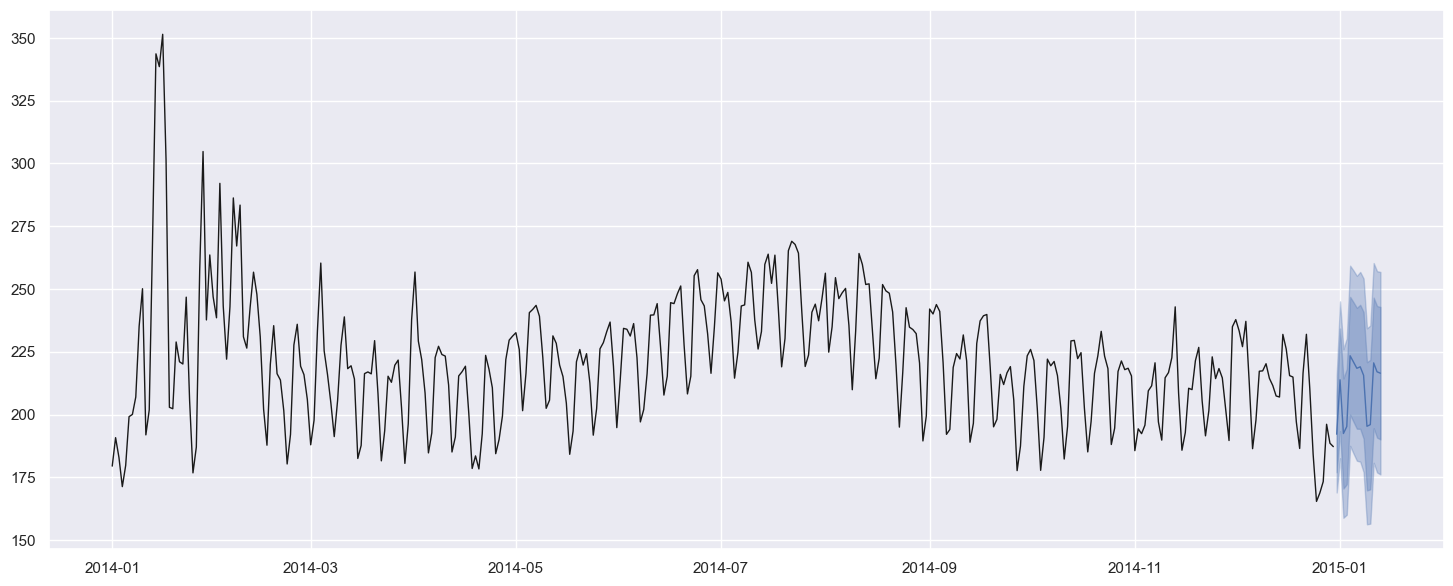

In [85]:
fig, ax = plt.subplots()
ax.plot(df2.Demand, 'k')

fc = fit.get_forecast(
    len(df_test),
    exog=df_test['Temperature Is_workday'.split()].astype(float))

ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
plt.show();